## Variational Autoencoders

The variationa autoencoders were introduced in this paper [link](https://arxiv.org/abs/1312.6114) and also a tutorial [link](https://arxiv.org/abs/1606.05908)

In [1]:
# %pip install -q numpy
# %pip install -q matplotlib
# %pip install -q torchinfo
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchinfo import summary
from tqdm import tqdm

In [3]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    if device.type == 'cuda':
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # torch.set_float32_matmul_precision("medium")

print(f"Available device: {device.type}")

Available device: cuda


### Dataset Download

In [4]:
transform_fn = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

In [5]:
DATA_PATH = '../datasets'
NUM_TRAIN = 60000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64
EPOCHS = 20

fashion_train = datasets.FashionMNIST(DATA_PATH, train=True, download=True, transform=transform_fn)
fashion_test = datasets.FashionMNIST(DATA_PATH, train=False, download=True, transform=transform_fn)


train_dataloader = DataLoader(fashion_train, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
valid_dataloader = DataLoader(fashion_test, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
test_dataloader = DataLoader(fashion_test, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(fashion_test))))

len(fashion_train), len(fashion_test)

(60000, 10000)

The image represents a class of: Pullover


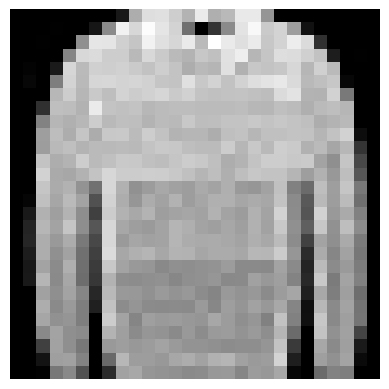

In [6]:
classes = test_dataloader.dataset.classes
num_classes = len(test_dataloader.dataset.classes)

def plot_figure(image):
    plt.imshow(np.transpose(image, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_dataloader))
print(f'The image represents a class of: {classes[test_dataloader.dataset[rnd_sample_idx][1]]}')
x = test_dataloader.dataset[rnd_sample_idx][0]
plot_figure(x)

### Baseline Model Implementation

In [7]:
class VAE(nn.Module):

    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        self.flat = nn.Flatten()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = F.relu(self.d1(x))
        h = F.relu(self.d2(x))
        return self.d31(h), self.d32(h)

    def sampling(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return (eps * std) + mean

    def decoder(self, z):
        z = F.relu(self.d4(z))
        z = F.relu(self.d5(z))
        return F.sigmoid(self.d6(z))

    def forward(self, x):
        mean, log_var = self.encoder(self.flat(x))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

### Train Functions

In [8]:
def train_batch(model: nn.Module, optimizer, loss_fn, data: torch.Tensor):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_fn(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

In [9]:
@torch.no_grad()
def valid_batch(model: nn.Module, loss_fn, data: torch.Tensor):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_fn(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [10]:
def loss_function(x_hat, x, mean, log_var):
    mse = F.mse_loss(x_hat, x.view(-1, 784), reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return mse + kld, mse, kld

In [11]:
model_vae = VAE(784, 512, 256, 50).to(device)
optimizer = torch.optim.AdamW(model_vae.parameters(), lr=1e-3)

In [12]:
def train(
    model: nn.Module, optimizer, loss_fn, train_dataloader, test_dataloader, epochs=10
):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        print(f"Epoch={epoch}", end="\t")
        N = len(train_dataloader)
        epoch_res = torch.zeros(N)
        for i, (data, _) in tqdm(enumerate(train_dataloader)):
            loss, _, _, _, _ = train_batch(model, optimizer, loss_fn, data)
            epoch_res[i] = loss.item()
        train_losses.append(epoch_res.mean())

        print(f"Train Loss={epoch_res.mean().item()}", end="\t")

        N = len(test_dataloader)
        epoch_res = torch.zeros(N)
        for i, (data, _) in enumerate(test_dataloader):
            loss, _, _, _, _ = valid_batch(model, loss_fn, data)
            epoch_res[i] = loss.item()
        valid_losses.append(epoch_res.mean())

        print(f"Valid Loss={epoch_res.mean().item()}", end="\n")

        with torch.no_grad():
            z = torch.randn(64, 50).to(device)
            sample = model.decoder(z).to(device)
            images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0)
            images = images.cpu().detach().numpy().copy()
            plt.imshow(images)
            plt.axis('off')
            plt.show()

    return train_losses, valid_losses

### Training

Epoch=0	

938it [00:12, 75.74it/s]


Train Loss=2389.750244140625	Valid Loss=1826.9268798828125


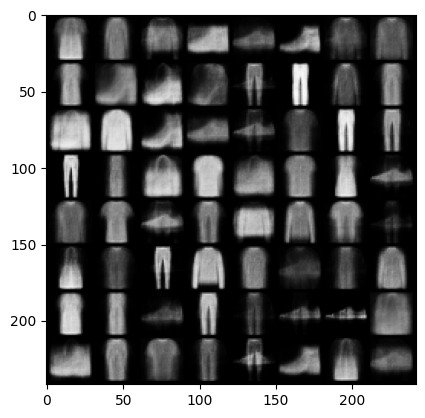

Epoch=1	

938it [00:12, 73.56it/s]


Train Loss=1740.646484375	Valid Loss=1675.29052734375


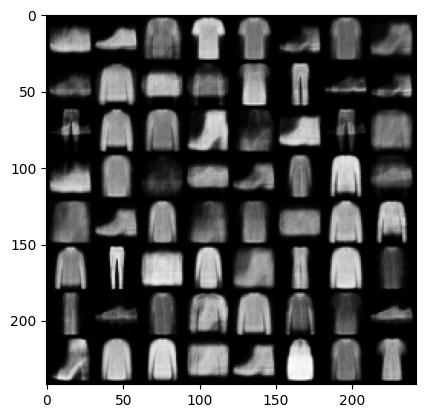

Epoch=2	

938it [00:12, 76.53it/s]


Train Loss=1658.432861328125	Valid Loss=1625.93896484375


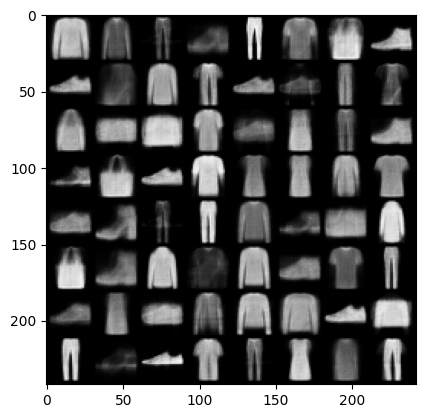

Epoch=3	

938it [00:12, 75.78it/s]


Train Loss=1623.7542724609375	Valid Loss=1601.7061767578125


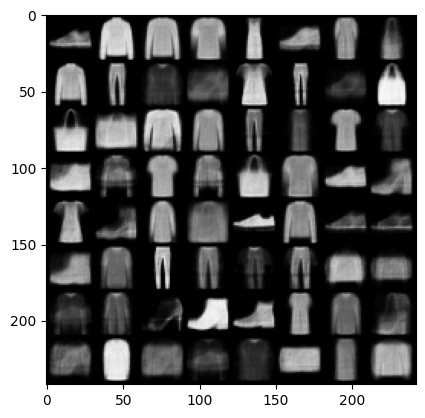

Epoch=4	

938it [00:12, 75.72it/s]


Train Loss=1601.25341796875	Valid Loss=1577.6002197265625


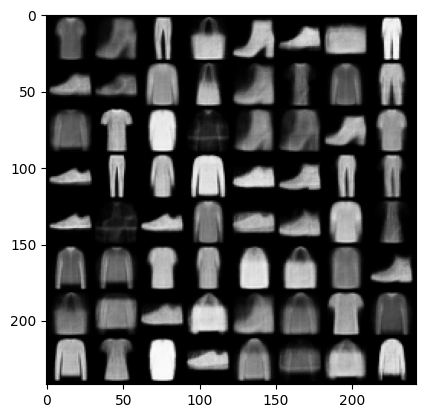

Epoch=5	

938it [00:12, 74.76it/s]


Train Loss=1587.52099609375	Valid Loss=1612.4583740234375


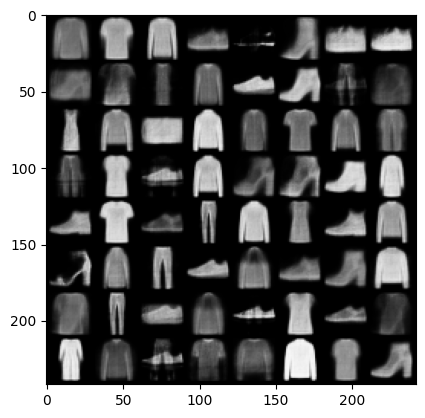

Epoch=6	

938it [00:12, 74.10it/s]


Train Loss=1573.8511962890625	Valid Loss=1559.875244140625


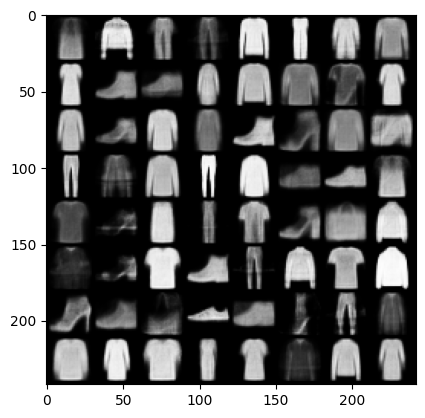

Epoch=7	

938it [00:12, 74.52it/s]


Train Loss=1565.6212158203125	Valid Loss=1554.2403564453125


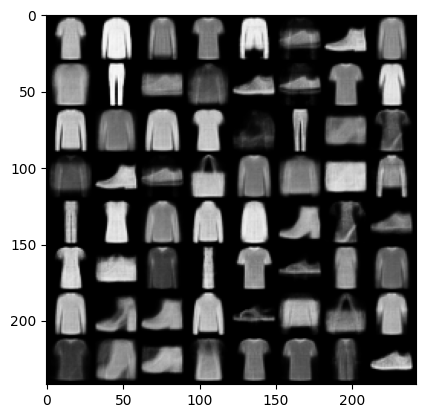

Epoch=8	

938it [00:12, 73.18it/s]


Train Loss=1556.9903564453125	Valid Loss=1548.5650634765625


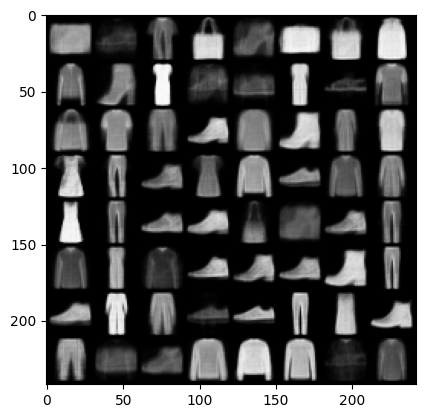

Epoch=9	

938it [00:12, 73.28it/s]


Train Loss=1549.9005126953125	Valid Loss=1536.09716796875


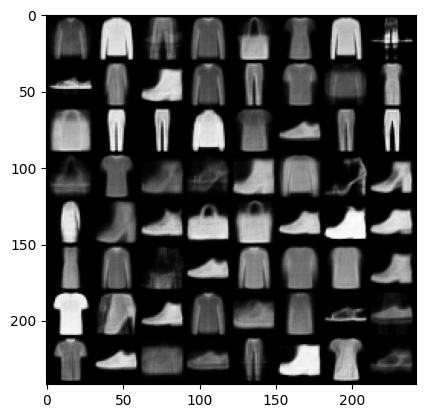

Epoch=10	

938it [00:12, 74.62it/s]


Train Loss=1544.45654296875	Valid Loss=1534.2445068359375


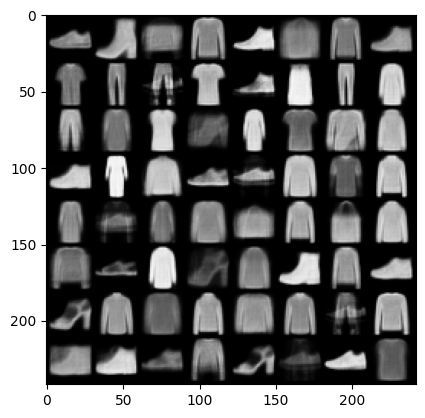

Epoch=11	

938it [00:13, 72.08it/s]


Train Loss=1537.3775634765625	Valid Loss=1524.2794189453125


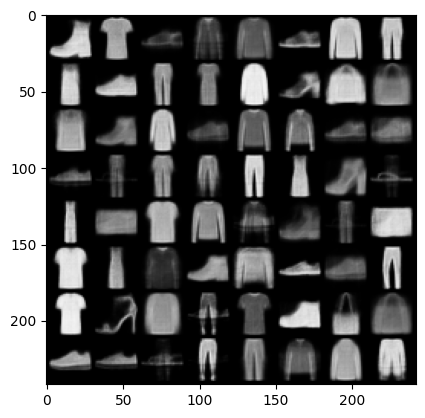

Epoch=12	

938it [00:12, 73.92it/s]


Train Loss=1530.345703125	Valid Loss=1528.0018310546875


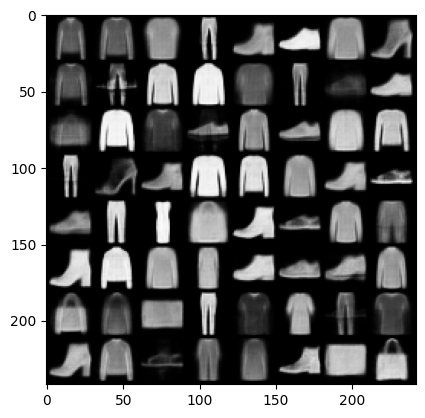

Epoch=13	

938it [00:13, 70.48it/s]


Train Loss=1526.669921875	Valid Loss=1518.4361572265625


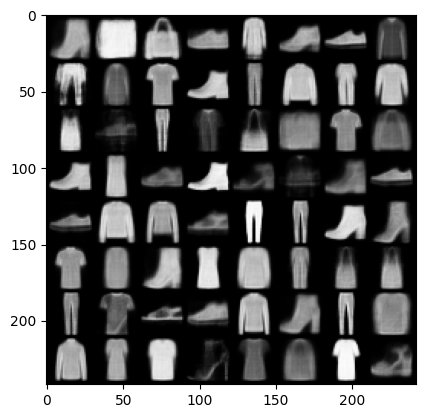

Epoch=14	

938it [00:13, 71.69it/s]


Train Loss=1522.380859375	Valid Loss=1502.208740234375


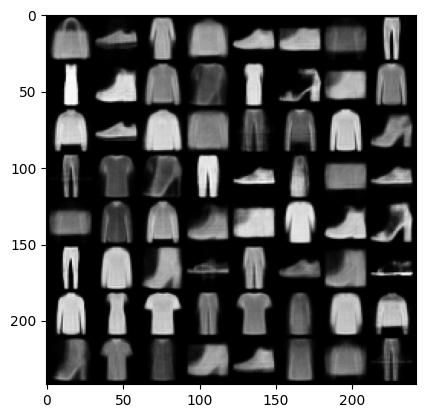

Epoch=15	

938it [00:13, 68.99it/s]


Train Loss=1518.186279296875	Valid Loss=1510.61474609375


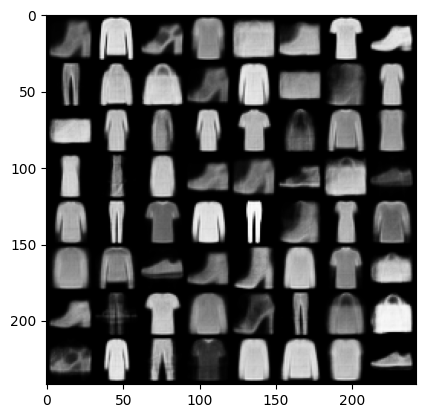

Epoch=16	

938it [00:13, 71.27it/s]


Train Loss=1515.972412109375	Valid Loss=1500.0223388671875


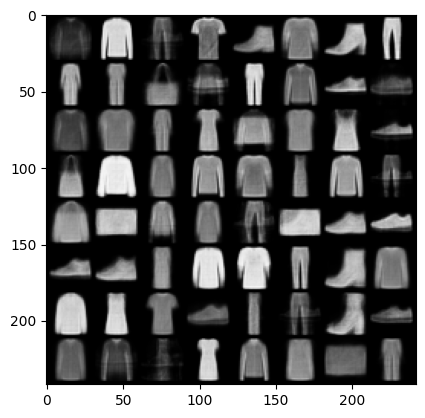

Epoch=17	

938it [00:13, 71.76it/s]


Train Loss=1511.7802734375	Valid Loss=1510.478271484375


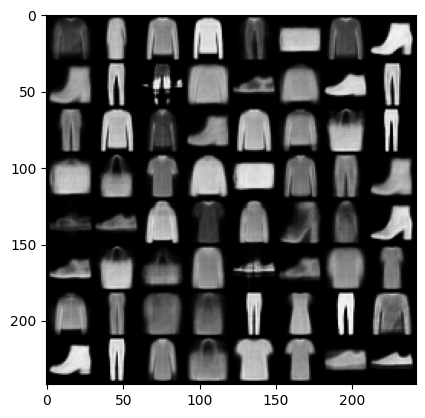

Epoch=18	

938it [00:13, 68.57it/s]


Train Loss=1508.7506103515625	Valid Loss=1499.68212890625


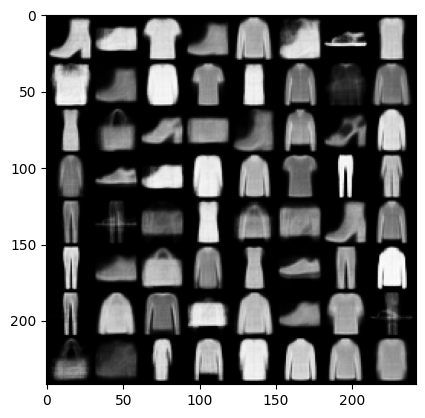

Epoch=19	

938it [00:13, 69.23it/s]


Train Loss=1505.5465087890625	Valid Loss=1507.3016357421875


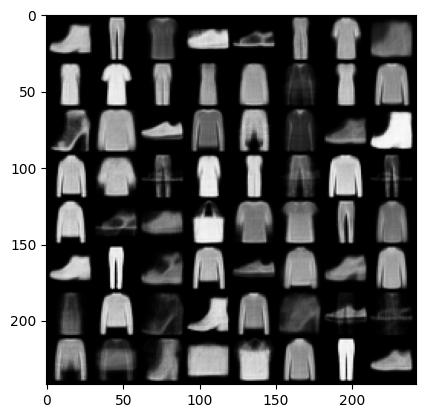

In [13]:
results_train, results_valid = train(
    model_vae,
    optimizer,
    loss_function,
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    epochs=EPOCHS,
)

### Results

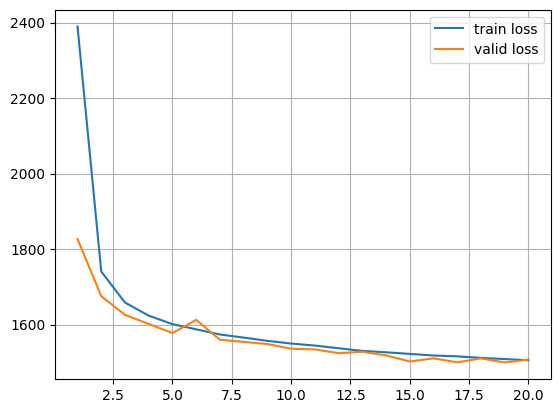

In [14]:
xaxis = np.arange(1, EPOCHS + 1)
results_train = np.array(results_train)
results_valid = np.array(results_valid)


plt.plot(xaxis, results_train, label='train loss')
plt.plot(xaxis, results_valid, label='valid loss')
plt.grid(True)
plt.legend()

### Convolutional Model

In [15]:
class ConvolutionaAutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder_ = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
        )

        self.decoder_ = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=3),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
            nn.Tanh(),
        )

        self.mean_proj = nn.Sequential(nn.Flatten(), nn.Linear(256, 50))

        self.log_var_proj = nn.Sequential(nn.Flatten(), nn.Linear(256, 50))

    def encoder(self, x):
        h = self.encoder_(x)
        return self.mean_proj(h), self.log_var_proj(h)

    def sampling(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * (std + mean)

    def decoder(self, z):
        h = self.decoder_(z)
        return h

    def forward(self, x):
        mean, log_var = self.encoder_(x)
        z = self.sampling(mean, log_var)
        x = self.decoder_(z)
        return x, mean, log_var

Epoch=0	

938it [00:13, 71.19it/s]


Train Loss=1502.9246826171875	Valid Loss=1496.51416015625


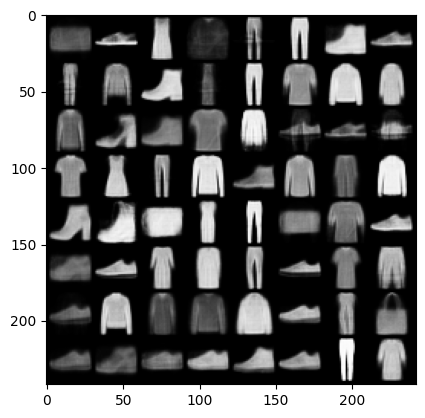

Epoch=1	

938it [00:12, 73.27it/s]


Train Loss=1501.74169921875	Valid Loss=1489.3614501953125


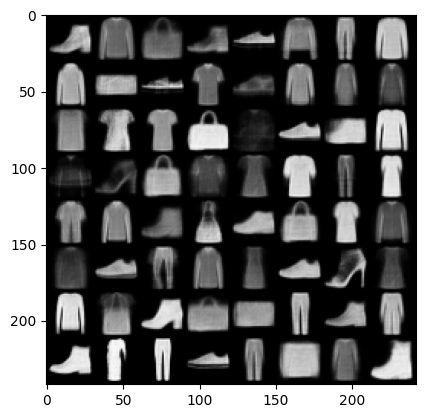

Epoch=2	

938it [00:12, 73.16it/s]


Train Loss=1497.2041015625	Valid Loss=1494.1212158203125


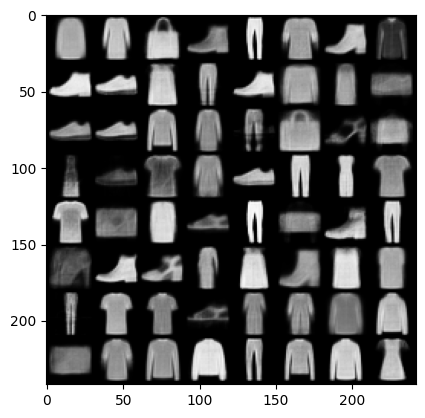

Epoch=3	

938it [00:13, 71.42it/s]


Train Loss=1497.7811279296875	Valid Loss=1501.57080078125


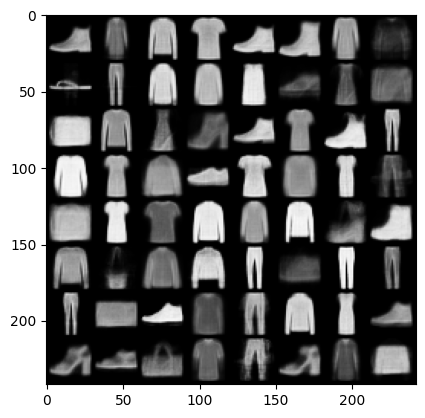

Epoch=4	

938it [00:12, 73.07it/s]


Train Loss=1493.9561767578125	Valid Loss=1487.8419189453125


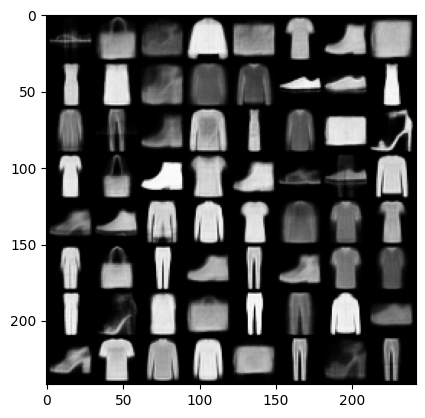

Epoch=5	

938it [00:12, 72.81it/s]


Train Loss=1493.39404296875	Valid Loss=1493.453125


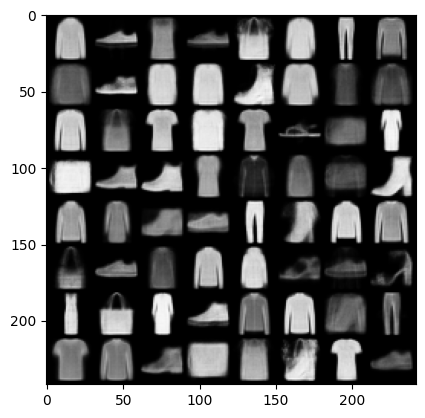

Epoch=6	

938it [00:13, 68.79it/s]


Train Loss=1492.50244140625	Valid Loss=1490.471923828125


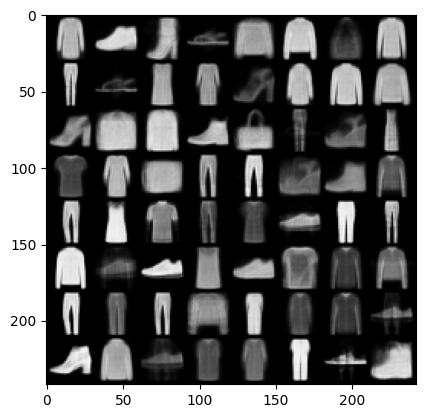

Epoch=7	

938it [00:20, 45.48it/s]


Train Loss=1491.4703369140625	Valid Loss=1491.2418212890625


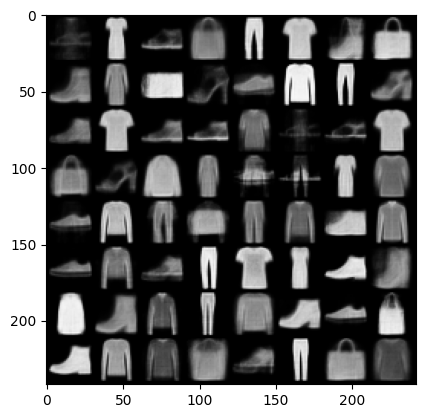

Epoch=8	

938it [00:15, 60.08it/s]


Train Loss=1489.316650390625	Valid Loss=1492.3411865234375


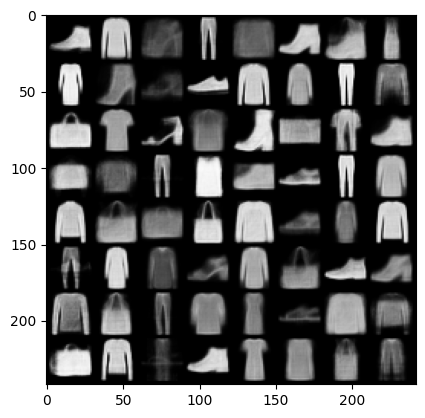

Epoch=9	

938it [00:14, 64.26it/s]


Train Loss=1489.389892578125	Valid Loss=1486.702880859375


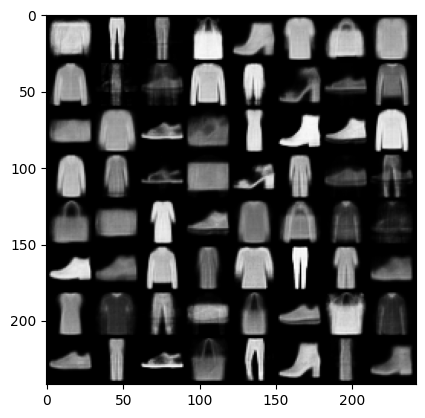

In [16]:
results_train, results_valid = train(
    model_vae,
    optimizer,
    loss_function,
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    epochs=10,
)

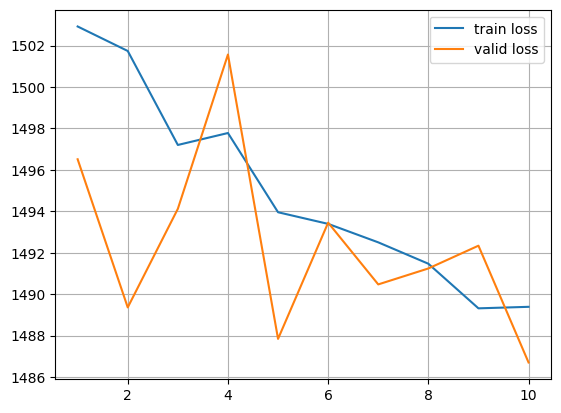

In [17]:
xaxis = np.arange(1, 11)
results_train = np.array(results_train)
results_valid = np.array(results_valid)


plt.plot(xaxis, results_train, label='train loss')
plt.plot(xaxis, results_valid, label='valid loss')
plt.grid(True)
plt.legend()